# Project 2: APS System Failure

## Project Outcomes


*   Visualize the data and pre-process it
*   Explore Feature Selection
*   Train a model to predict the likelihood of APS failure at a specific point in the data

Kaggle Link: https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set/code?datasetId=13327&sortBy=voteCount

##1.0 Pre-process and Visualize

#####1.1 Import Data and Libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from random import randint
import decimal

In [ ]:
# Import dataset
train_df = pd.read_csv('aps_failure_training_set.csv')
test_df = pd.read_csv('aps_failure_test_set.csv')
# Lets take a look at the data
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


#####1.2 Handle Missing Values

In [ ]:
# We noticed that empty data was entered as the string 'na' and not null so lets fix that
train_df = train_df.replace('na', np.NaN)
test_df = test_df.replace('na', np.NaN)
# Lets paramaterize the Class column
train_df = train_df.replace('neg', 0)
train_df = train_df.replace('pos', 1)
test_df = test_df.replace('neg', 0)
test_df = test_df.replace('pos', 1)
train_df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,...,NaN,NaN,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,...,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,...,0,2578,76,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,42124,372236,2128914,...,0,3590004,2026,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [ ]:
# We noticed that the numeric values were imported as string values so lets convert them to floats to process
for col in train_df:
  train_df[col] = train_df[col].astype(float)
  test_df[col] = test_df[col].astype(float)

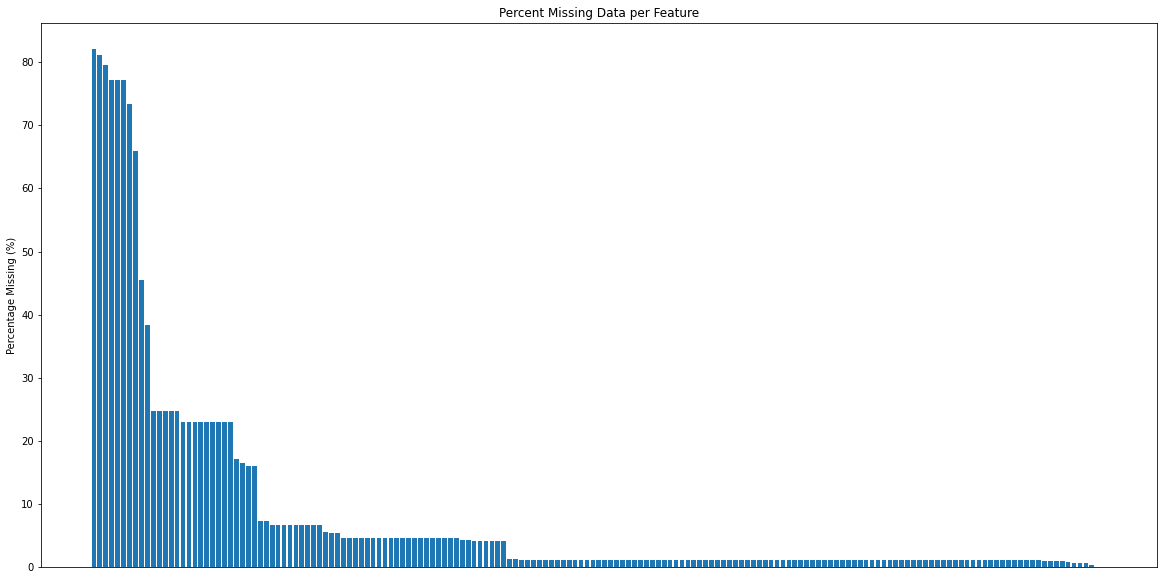

In [ ]:
# Lets explore and visualize how much missing data we have
missing = train_df.isna().sum().div(train_df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage Missing (%)")
plt.title('Percent Missing Data per Feature')
plt.show()

In [ ]:
# Lets remove features which are mostly missing data 
drop_features = missing[missing[0]>50]
print(f"Drop the following columns whose columns are half empty: {drop_features}")

Drop the following columns whose columns are half empty:                 0
br_000  82.106667
bq_000  81.203333
bp_000  79.566667
bo_000  77.221667
ab_000  77.215000
cr_000  77.215000
bn_000  73.348333
bm_000  65.915000


In [ ]:
# Actually remove them
columns = list(drop_features.index)
columns.append('class')

# Seperate into feature and label sets 
train_features = train_df.drop(columns, axis=1)
train_labels = train_df.loc[:,'class']
test_features = test_df.drop(columns, axis=1)
test_labels = test_df.loc[:, 'class']
print(train_features.shape)
print(test_features.shape)

(60000, 162)
(16000, 162)


#####1.3 Check for Outliers & Remove if appropriate

In [ ]:
# Impute NaN Values
train_features.fillna(train_features.mean(), inplace=True)
test_features.fillna(test_features.mean(), inplace=True)

#####1.4 Normalize the Data

In [ ]:
# Normalize Data
"""
Nomalize each features based on the features mean and standard deviation. 
Standardize acorrding the the following formulation:
z = (x-mean)/stddev

Note: Standardize test features set with training set parameters. This will 
ensure we develop a model which is generalized to be able to accept real world
unseen values.
"""
for col in train_features:
  mean = train_features[col].mean()
  std = train_features[col].std()
  train_features[col] = (train_features[col] - mean)/std 
  # Standardize test set based on training set's statistics
  test_features[col] = (test_features[col] - mean)/std 
train_features

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119380,2.297432,-5.431297e-03,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.169357,0.100018,0.516105,0.359329,-0.044190,-0.030317,0.178173,-0.055516,-0.022830,-0.013418,-0.110200,-0.110391,0.190004,0.096188,0.248006,0.548961,-0.092276,-0.011572,-0.042627,-0.014671,-0.016383,-0.073254,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,0.257459,0.969500,-0.165972,-0.074394,...,7.116179e-02,8.679034e-01,0.172609,0.454987,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,0.294875,0.959097,1.894524,-0.047555,-0.152667,0.555785,0.682070,0.945579,0.630333,-0.195083,-0.134413,-0.020407,-0.029976,-0.167477,0.339258,0.389774,0.096754,0.361167,0.691896,0.522436,0.236976,0.068038,0.005735,-0.109590,-0.146549,-0.177715,-0.021220,-0.024659
1,-0.180695,-0.460879,-1.105351e-15,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.177403,-0.140270,0.016201,0.012309,-0.017942,-0.030317,-0.100063,-0.055516,-0.021473,-0.013418,-0.110200,-0.110391,-0.116169,-0.128985,0.026185,-0.082675,-0.092276,-0.011572,-0.042627,-0.014671,-0.173047,-0.257894,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,-0.029182,-0.093797,0.088801,-0.239769,...,-5.791800e-15,-1.023951e-13,0.020184,0.088987,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,-0.000098,0.140993,-0.075003,-0.047555,-0.152667,0.067227,0.025758,0.039937,0.134981,-0.195083,-0.134413,-0.020407,-0.029976,-0.151091,0.266592,0.272827,-0.028677,0.015761,-0.020965,-0.061196,-0.131204,-0.133240,-0.187557,-0.154293,-0.092069,-0.145938,-0.021220,-0.024659
2,-0.125810,-0.460879,-5.436434e-03,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.184436,-0.227408,0.058021,-0.145869,-0.107592,-0.030317,-0.138308,-0.055516,-0.022830,-0.013418,-0.110200,-0.110391,-0.140548,-0.122135,-0.228968,-0.229815,-0.092276,-0.011572,-0.042627,-0.014671,-0.117626,-0.182109,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,-0.080748,-0.063822,-0.257257,0.100585,...,-2.083091e-01,3.890275e-02,-0.174963,-0.135218,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,-0.205316,0.161645,0.086496,-0.047555,-0.152667,-0.117410,-0.147449,-0.332551,-0.268193,-0.195083,-0.134413,-0.020407,-0.029976,-0.210123,-0.103855,-0.133701,-0.196191,-0.129317,-0.146304,-0.094979,-0.018715,0.014010,-0.011581,-0.109551,-0.097546,-0.166826,-0.021220,-0.024659
3,-0.407925,-0.460879,-5.437404e-03,-0.04312,-0.004902,-0.010884,-0.02869,-0.057573,-0.116539,-0.184198,-0.340640,-0.425971,-0.352922,-0.162481,-0.030317,-0.434106,-0.055516,-0.022830,-0.013418,-0.109004,-0.105783,-0.445354,-0.441336,-0.323383,-0.351354,-0.092276,-0.011572,-0.042627,-0.014671,-0.163758,-0.253760,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,-0.080748,-0.330788,-0.304083,-0.263445,...,-2.083091e-01,-6.095338e-01,-0.327173,-0.189755,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,-0.346303,-0.476337,-0.510362,-0.047534,-0.152389,-0.440513,-0.465885,-0.357724,-0.290897,-0.190109,-0.133653,-0.020407,-0.029976,-0.235311,-0.419792,-0.432565,-0.302892,-0.306104,-0.387490,-0.390693,-0.383621,-0.353352,-0.313261,-0.201512,-0.310365,-0.177715,0.915871,3.684226
4,0.010572,-0.460877,-5.426218e-03,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.166603,0.264538,0.036662,-0.259872,-0.141523,-0.030317,0.039419,-0.055516,-0.018319,-0.013418,-0.110200,-0.110391,-0.029736,-0.056523,0.0175

In [ ]:
# Remove columns full of zeros
'''
When we standardize the dataset this introduces columns full of NaN. 
Lets remove the columns before that happens
'''
train_features.dropna(axis=1, how='all', inplace=True)
test_features.dropna(axis=1, how='all', inplace=True)
train_features.head()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,...,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119380,2.297432,-5.431297e-03,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.169357,0.100018,0.516105,0.359329,-0.044190,-0.030317,0.178173,-0.055516,-0.022830,-0.013418,-0.110200,-0.110391,0.190004,0.096188,0.248006,0.548961,-0.092276,-0.011572,-0.042627,-0.014671,-0.016383,-0.073254,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,0.257459,0.969500,-0.165972,-0.074394,...,7.116179e-02,8.679034e-01,0.172609,0.454987,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,0.294875,0.959097,1.894524,-0.047555,-0.152667,0.555785,0.682070,0.945579,0.630333,-0.195083,-0.134413,-0.020407,-0.029976,-0.167477,0.339258,0.389774,0.096754,0.361167,0.691896,0.522436,0.236976,0.068038,0.005735,-0.109590,-0.146549,-0.177715,-0.021220,-0.024659
1,-0.180695,-0.460879,-1.105351e-15,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.177403,-0.140270,0.016201,0.012309,-0.017942,-0.030317,-0.100063,-0.055516,-0.021473,-0.013418,-0.110200,-0.110391,-0.116169,-0.128985,0.026185,-0.082675,-0.092276,-0.011572,-0.042627,-0.014671,-0.173047,-0.257894,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,-0.029182,-0.093797,0.088801,-0.239769,...,-5.791800e-15,-1.023951e-13,0.020184,0.088987,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,-0.000098,0.140993,-0.075003,-0.047555,-0.152667,0.067227,0.025758,0.039937,0.134981,-0.195083,-0.134413,-0.020407,-0.029976,-0.151091,0.266592,0.272827,-0.028677,0.015761,-0.020965,-0.061196,-0.131204,-0.133240,-0.187557,-0.154293,-0.092069,-0.145938,-0.021220,-0.024659
2,-0.125810,-0.460879,-5.436434e-03,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.184436,-0.227408,0.058021,-0.145869,-0.107592,-0.030317,-0.138308,-0.055516,-0.022830,-0.013418,-0.110200,-0.110391,-0.140548,-0.122135,-0.228968,-0.229815,-0.092276,-0.011572,-0.042627,-0.014671,-0.117626,-0.182109,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,-0.080748,-0.063822,-0.257257,0.100585,...,-2.083091e-01,3.890275e-02,-0.174963,-0.135218,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,-0.205316,0.161645,0.086496,-0.047555,-0.152667,-0.117410,-0.147449,-0.332551,-0.268193,-0.195083,-0.134413,-0.020407,-0.029976,-0.210123,-0.103855,-0.133701,-0.196191,-0.129317,-0.146304,-0.094979,-0.018715,0.014010,-0.011581,-0.109551,-0.097546,-0.166826,-0.021220,-0.024659
3,-0.407925,-0.460879,-5.437404e-03,-0.04312,-0.004902,-0.010884,-0.02869,-0.057573,-0.116539,-0.184198,-0.340640,-0.425971,-0.352922,-0.162481,-0.030317,-0.434106,-0.055516,-0.022830,-0.013418,-0.109004,-0.105783,-0.445354,-0.441336,-0.323383,-0.351354,-0.092276,-0.011572,-0.042627,-0.014671,-0.163758,-0.253760,-0.02702,-0.019145,-0.025767,-0.035194,-0.029963,-0.080748,-0.330788,-0.304083,-0.263445,...,-2.083091e-01,-6.095338e-01,-0.327173,-0.189755,-0.020492,-0.027844,-0.008697,-0.090631,-0.00912,-0.028931,-0.026966,-0.029553,-0.346303,-0.476337,-0.510362,-0.047534,-0.152389,-0.440513,-0.465885,-0.357724,-0.290897,-0.190109,-0.133653,-0.020407,-0.029976,-0.235311,-0.419792,-0.432565,-0.302892,-0.306104,-0.387490,-0.390693,-0.383621,-0.353352,-0.313261,-0.201512,-0.310365,-0.177715,0.915871,3.684226
4,0.010572,-0.460877,-5.426218e-03,-0.04312,-0.053594,-0.010884,-0.02869,-0.057573,-0.116958,-0.166603,0.264538,0.036662,-0.259872,-0.141523,-0.030317,0.039419,-0.055516,-0.018319,-0.013418,-0.110200,-0.110391,-0.029736,-0.056523,0.0175

#####1.5 Visualize the Data

In [ ]:
#sns.pairplot(train_features[train_features.columns[0:5][0:25]])

#####1.6 Address Class Imbalance

In [ ]:
# Down Sampled Dataset will be used for model learning for Report 3
# Reconnect feature and label
train_features.insert(loc=0, column='class', value=train_labels)
train_df = train_features.copy()
train_df.rename(columns={0:'class'}, inplace=True)
# Split into majority and minority classes
df_majority = train_df[train_df['class']==0]
df_minority = train_df[train_df['class']==1]

# Downsample majority class
df_majority_downsampled = sklearn.utils.resample(df_majority, replace=False, n_samples=1000)

# Combine back with minority
train_features_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display Balance

num_neg = (train_features_downsampled['class'] == 0).sum()
num_pos = (train_features_downsampled['class'] == 1).sum()
print(f"After down sampling there are now {num_neg} negative class data points and {num_pos} positive class data points")

After down sampling there are now 1000 negative class data points and 1000 positive class data points


##2.0 Feature Selection

#####2.1 Principal Component Analysis

In [ ]:
#Principal Component Analysis to extract the most useful principal components
pca = decomposition.PCA(n_components=3)
principalComponents = pca.fit_transform(train_features)
pc_df = pd.DataFrame(data = principalComponents, columns = [('PC ' + str(i)) for i in range(1,pca.n_components_+1)])
print(f"Number of principal components which account for 90% of varriance is {pca.n_components_}")
pc_df.head()

Number of principal components which account for 90% of varriance is 3


,PC 1,PC 2,PC 3
0,2.349668,-1.307068,1.700318
1,-0.614079,-0.480816,0.081673
2,-1.261962,-0.140123,-0.240690
3,-3.263661,0.240188,-0.781486
4,0.272060,-0.164137,0.793919


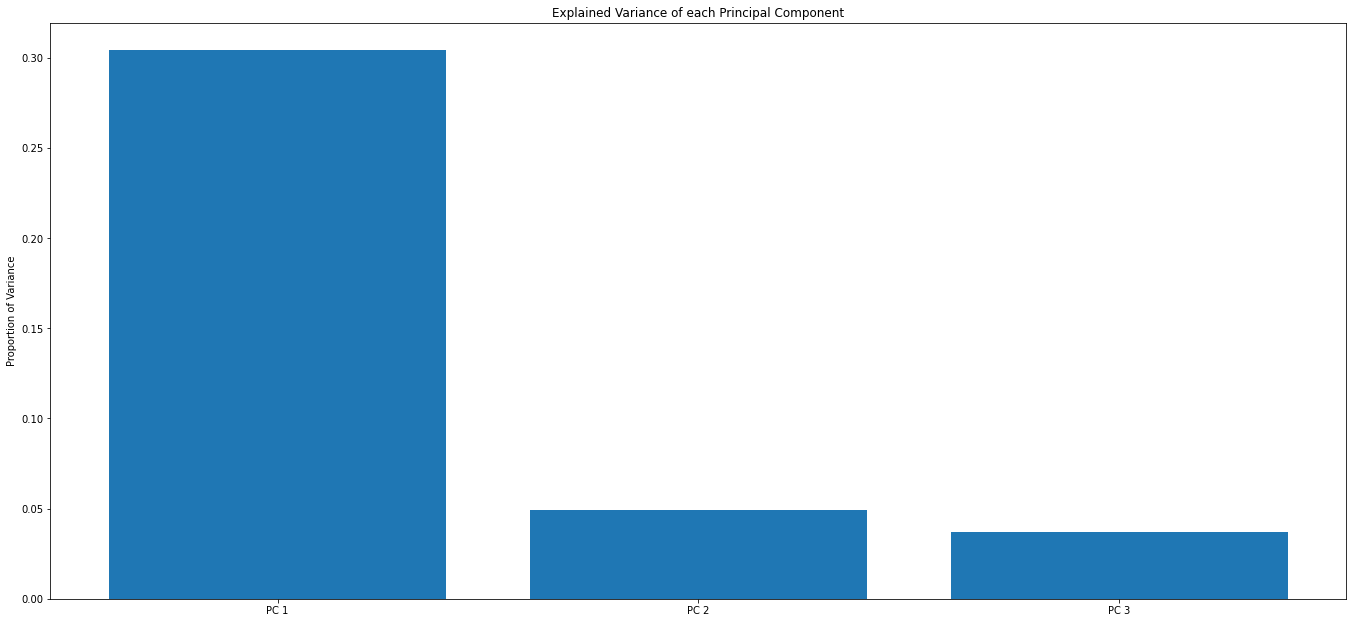

In [ ]:
pcs = [('PC ' + str(i)) for i in range(1,pca.n_components_+1)]
pc_variance = pca.explained_variance_ratio_

fig= plt.figure()
ax = fig.add_axes([0,0,3,2])
ax.bar(pcs, pc_variance)
ax.set_title('Explained Variance of each Principal Component')
ax.set_ylabel('Proportion of Variance')
plt.show()

In [ ]:
# Lets add the class column for graphing!
pc_df.insert(loc=0, column='class', value=train_labels)
pc_df

,class,PC 1,PC 2,PC 3
0,0.0,2.349668,-1.307068,1.700318
1,0.0,-0.614079,-0.480816,0.081673
2,0.0,-1.261962,-0.140123,-0.240690
3,0.0,-3.263661,0.240188,-0.781486
4,0.0,0.272060,-0.164137,0.793919
...,...,...,...,...
59995,0.0,4.820882,-1.509916,1.610814
59996,0.0,-3.138650,0.134674,-0.694624
59997,0.0,-3.260130,0.138736,-0.811264
59998,0.0,2.353717,-2.709729,1.855650


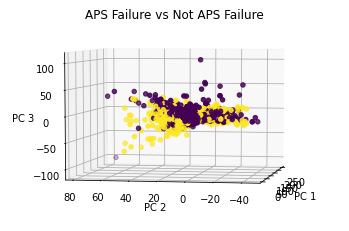

In [ ]:
#3D plot from PCA
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(pc_df['PC 1'], pc_df['PC 2'], pc_df['PC 3'], c=pc_df['class'])

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.set_label('test')
ax.view_init(elev=5, azim=190)
ax.set_title("APS Failure vs Not APS Failure")

plt.show()

The above method identifies linear combinations of the initial features to identify principal components of the data which are able to account for the data variance. These principal components could be used to train a model and estimate record class as well as being very useful in visualizing the data.

#####2.2 Select K Best

In [ ]:
# Select k best features as an estimator
selector = SelectKBest(k=10)
selector.fit(train_features, train_labels)
best_features = selector.get_support(indices=True)
kbest_train_features = train_features.iloc[:,best_features]
print(f"Through k Best feature selection the best features were {kbest_train_features.columns}")

Through k Best feature selection the best features were Index(['class', 'aa_000', 'aq_000', 'bb_000', 'bj_000', 'bt_000', 'bu_000',
       'bv_000', 'ci_000', 'cq_000'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


#####2.3 Forward Feature Selection

In [ ]:
"""knn = KNeighborsClassifier(n_neighbors=2)
forward = SequentialFeatureSelector(knn, n_features_to_select=3, direction='forward')
forward.fit(train_features, train_labels)
forward.get_support(indices=True)"""

"knn = KNeighborsClassifier(n_neighbors=2)\nforward = SequentialFeatureSelector(knn, n_features_to_select=3, direction='forward')\nforward.fit(train_features, train_labels)\nforward.get_support(indices=True)"

#####2.4 Backward Features Selection


In [ ]:
"""knn = KNeighborsClassifier(n_neighbors=2)
forward = SequentialFeatureSelector(knn, n_features_to_select=3, direction='backward')
forward.fit(train_features, train_labels)
forward.get_support(indices=True)"""

"knn = KNeighborsClassifier(n_neighbors=2)\nforward = SequentialFeatureSelector(knn, n_features_to_select=3, direction='backward')\nforward.fit(train_features, train_labels)\nforward.get_support(indices=True)"

### 3.0 Model Implementation

In [ ]:
# Split downsampled dataframe into label and feature df's
train_labels = train_features_downsampled['class']
train_features = train_features_downsampled.drop(labels='class', axis=1)

##### 3.1 Logistic Regression

In [ ]:
# Hyper parameter Tuning for logistic regression
penalty = ['l1','l2']
regularization = [0.001, 0.01, 0.1, 1, 10, 100]
solver = ['liblinear', 'saga']
maxScore = 0
hyperparams = []
for p in penalty:
  for r in regularization:
    for s in solver:
      model1 = LogisticRegression(random_state=0, penalty=p, C=r, solver=s).fit(train_features, train_labels)
      pred_1 = model1.predict(test_features)
      score = model1.score(test_features, test_labels)
      if score > maxScore:
        maxScore = score
        hyperparams.clear()
        hyperparams.append([p,r,s])
print(f"The Maximum score was: {maxScore} with the following hyperparameters: {hyperparams}")

model1 = LogisticRegression(random_state=0, penalty='l1', C=100, solver='liblinear').fit(train_features, train_labels)
pred_1 = model1.predict(test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was r

The Maximum score was: 0.9685625 with the following hyperparameters: [['l1', 100, 'liblinear']]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
# Just to see how many predictions were positive and negative
pred1 = pd.DataFrame(data=pred_1)
pred1.value_counts()

0.0    15174
1.0      826
dtype: int64

##### 3.2 SVM Classification

In [ ]:
# Hyper parameter Tuning for SVM
C = [0.1, 1, 10]
kernel = ['linear', 'poly','rbf'] 
degree = [3,5,7,] # only in poly kernel
gamma = ['scale','auto'] # only rbf, poly

maxScore = 0
hyperparams = []

for reg in C:
  for k in kernel:
    for d in degree:        
      for g in gamma:
        if k is 'poly':
          # Itterate over degree and gamma
          model2 = SVC(C=reg, kernel=k, degree=d, gamma=g).fit(train_features, train_labels)
        if k is 'rbf':
          # Itterate over gamma
          model2 = SVC(C=reg, kernel=k, gamma=g).fit(train_features, train_labels)
        else:
          # Don't include degree or gamma
          model2 = SVC(C=reg, kernel=k).fit(train_features, train_labels)
        pred_2 = model2.predict(test_features)
        score = model2.score(test_features, test_labels)
        if score > maxScore:
          maxScore = score
          hyperparams.clear()
          hyperparams.append([reg, k, d, g])
print(f"The best SVM Model score is {maxScore} with hyperparamaters: {hyperparams}")

The best SVM Model score is 0.9803125 with hyperparamaters: [[0.1, 'poly', 3, 'scale']]


In [ ]:
model2 = SVC(C=0.1, kernel='poly', degree=3, gamma='scale').fit(train_features, train_labels)
pred_2 = model2.predict(test_features)
score = model2.score(test_features, test_labels)
print(f"The score for with the tunned hyperparameters is: {score}")

The score for with the tunned hyperparameters is: 0.9803125


In [ ]:
# Just to see how many predictions were positive and negative
pred2 = pd.DataFrame(data=pred_2)
pred2.value_counts()

0.0    15602
1.0      398
dtype: int64

### 4.0 Kaggle Cost Function

The task defined a total cost for the prediction model. We will implement this model to compare our results with those of folks who competed

In [ ]:
def total_cost(y_pred, y_true):
  """
  Receives model predictions and ground truth
  Returns total cost as defined by the kaggle challenge
  Going through folks submissions the lost cost we saw was $9020
  """
  cost1, cost2 = 0, 0
  for i, val in enumerate(y_pred):
    if (val - y_true[i]) == 1:
      cost1 += 1
    elif (val - y_true[i]) == -1:
      cost2 += 1
  
  return cost1*10 + cost2*500

# Find Cost for each model
logRegCost = total_cost(pred_1, test_labels)
svmCost = total_cost(pred_2, test_labels)

print(f"The total cost for the Logistic Regression model was ${logRegCost}")
print(f"The total cost for the Support Vector Machine model was ${svmCost}")

The total cost for the Logistic Regression model was $17770
The total cost for the Support Vector Machine model was $74690
